In [1]:
from PIL import Image
import cv2
import numpy as np
from colorthief import ColorThief
import ms_ocr
from collections import Counter
from shapely.geometry import Polygon, LineString
from pylsd import lsd
import lsd_parser
import lsd_parser_slanted

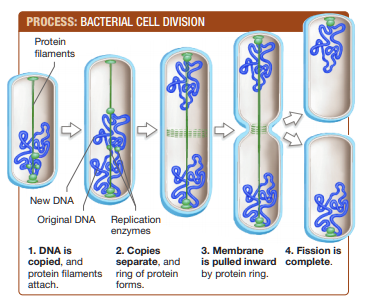

In [2]:
image_path = "imgs/11.png"
display(Image.fromarray(cv2.imread(image_path)))

In [3]:
def clear_bounding_boxes_from_image(boxes, img):
    for i in boxes:
        img[i[1]-5 : i[3]+5 , i[0]-5 : i[2]+5] = (255,255,255)
    return img

In [4]:
def get_ocr_bounding_boxes(image_path):
    ocr_boxes = []
    ocr_box_text_dict = {}
    res = ms_ocr.result_microsoft_api(image_path)
    for i in range(len(res[0]['lines'])):
        bbox = res[0]['lines'][i]['boundingBox']
        xmin = min(bbox[0],bbox[2],bbox[4],bbox[6])
        ymin = min(bbox[1],bbox[3],bbox[5],bbox[7])
        xmax = max(bbox[0],bbox[2],bbox[4],bbox[6])
        ymax = max(bbox[1],bbox[3],bbox[5],bbox[7])
        bounding_box = (xmin,ymin,xmax,ymax)
        ocr_box_text_dict[bounding_box] = res[0]['lines'][i]['text']
        ocr_boxes.append(bounding_box)
    return ocr_boxes, ocr_box_text_dict

In [5]:
def generate_color_palette(image):
    image_path = 'output.png'
    cv2.imwrite(image_path, image)
    image = Image.open(image_path)
    colors = Counter(image.getdata())
    color_palette = []
    for i in colors.keys():
        if colors[i] > 100:
            color_palette.append(i)
    return color_palette

In [6]:
def process_color_palette(color_palette):
    rgb = []
    for i in color_palette:
        rgb.append(tuple(i))
    buffer = 30
    for i in rgb:
        colors_to_remove = []
        for j in rgb:
            if i != j:
                if abs(i[0]-j[0]) < buffer and abs(i[1]-j[1]) < buffer and abs(i[2] - j[2]) < buffer:
                    colors_to_remove.append(j)
        for j in colors_to_remove:
            rgb.remove(j)
    white = (255,255,255)
    black = (0,0,0)
    if white in rgb:
        rgb.remove(white)
    if black in rgb:
        rgb.remove(black)
    return rgb

In [7]:
def color_filtering(rgb_colors, image_path):
    img = cv2.imread(image_path)
    bbox = []
    buffer = 10
    for c in rgb_colors:
        lower_limit = (max(0,c[0]-buffer) , max(0,c[1]-buffer) , max(0,c[2]-buffer))
        upper_limit = (min(255,c[0]+buffer) , min(255,c[1]+buffer) , min(255,c[2]+buffer))
        rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.inRange(rgb, lower_limit, upper_limit)
        result = cv2.bitwise_and(img, img, mask = mask)
        kernel = np.ones((1,1) , np.uint8)
        dilated_image = cv2.dilate(result, kernel, iterations = 3)
        contours, hirearchy = cv2.findContours(cv2.cvtColor(dilated_image, cv2.COLOR_BGR2GRAY) , cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        for c in contours:
            x,y,w,h = cv2.boundingRect(c)
            bbox.append((x,y,x+w,y+h))
    return bbox

In [8]:
def rectangle_and_rectangle_distance(box1 , box2):
    rectangle1 = Polygon([(box1[0],box1[1]) , (box1[0] , box1[3]) , (box1[2] , box1[3]) , (box1[2] , box1[1])])
    rectangle2 = Polygon([(box2[0],box2[1]) , (box2[0] , box2[3]) , (box2[2] , box2[3]) , (box2[2] , box2[1])])
    distance = rectangle1.distance(rectangle2)
    return distance

In [9]:
def join_bounding_boxes(box1, box2):
    xmin = min(box1[0],box1[2],box2[0], box2[2])
    xmax = max(box1[0],box1[2],box2[0], box2[2])
    ymin = min(box1[1],box1[3],box2[1],box2[3])
    ymax = max(box1[1],box1[3],box2[1],box2[3])
    return ((xmin,ymin,xmax,ymax))

In [10]:
def join_overlapping_boxes(boxes):
    while(True):
        overlap_counter = 0
        boxes_to_reject = []
        boxes_to_append = []
        for i in boxes:
            if i not in boxes_to_reject:
                for j in boxes:
                    if j not in boxes_to_reject:
                        if i != j:
                            if rectangle_and_rectangle_distance(i,j) < 5:
                                overlap_counter += 1
                                boxes_to_reject.append(i)
                                boxes_to_reject.append(j)
                                boxes_to_append.append(join_bounding_boxes(i,j))
        boxes_to_reject = list(set(boxes_to_reject))
        boxes_to_append = list(set(boxes_to_append))
        for i in boxes_to_reject:
            boxes.remove(i)
        for i in boxes_to_append:
            boxes.append(i)
        if overlap_counter == 0:
            break
    return boxes


In [11]:
def calculate_geometric_area(box):
    polygon = Polygon([(box[0],box[1]) , (box[0],box[3]) , (box[2],box[3]) , (box[2],box[3])])
    area = polygon.area
    return area

In [12]:
def reject_small_boxes(boxes):
    boxes_with_large_area = []
    for i in boxes:
        area = calculate_geometric_area(i)
        if area > 60 and abs(i[0]-i[2]) > 5 and abs(i[1]-i[3]) > 5:
            boxes_with_large_area.append(i)
        #if area > 90:
        #    boxes_with_large_area.append(i)
    return boxes_with_large_area

In [13]:
MINIMUM_DISTANCE_BETWEEN_OCR_BOXES = 4
def combine_ocr_boxes(ocr_boxes , ocr_box_combine_flag):
    if ocr_box_combine_flag == True:
        while(True):
            boxes_to_append = []
            for i in ocr_boxes:
                ocr_boxes_to_combine = [i]
                ocr_boxes_to_remove = [i]
                for j in ocr_boxes:
                    if j not in ocr_boxes_to_combine:
                        if rect_distance(i,j) <= MINIMUM_DISTANCE_BETWEEN_OCR_BOXES:
                            ocr_boxes_to_combine.append(j)
                            ocr_boxes_to_remove.append(j)
                xmin, ymin, xmax, ymax = 10000, 10000, 0, 0
                for j in ocr_boxes_to_combine:
                    if j[0] < xmin:
                        xmin = j[0]
                    if j[1] < ymin:
                        ymin = j[1]
                    if j[2] > xmax:
                        xmax = j[2]
                    if j[3] > ymax:
                        ymax = j[3]
                if len(ocr_boxes_to_combine) >1:
                    boxes_to_append.append((xmin,ymin,xmax,ymax))
                    for j in ocr_boxes_to_remove:
                        ocr_boxes.remove(j)
            if len(boxes_to_append) == 0:
                break
            else:
                for i in boxes_to_append:
                    ocr_boxes.append(i)
    return ocr_boxes

def get_combined_texts(ocr_boxes_combined, ocr_boxes_copy, ocr_box_text_dict, image_path):
    text_dict = {}
    img = cv2.imread(image_path)
    for i in ocr_boxes_combined:
        text_boxes_list = []
        for j in ocr_boxes_copy:
            if check_a_rectangle_insisde_other_rectangle(i,j) == True:
                text_boxes_list.append(j)
        text_boxes_list.sort(key = lambda x : get_contour_precedence(x, img.shape[1]))
        final_text = ""
        for j in text_boxes_list:
            final_text += ocr_box_text_dict[j] + " "
        text_dict[i] = final_text
    return text_dict

In [14]:
def distance_between_points(point1 , point2):
    x1 , y1 = point1[0] , point1[1]
    x2 , y2 = point2[0] , point2[1]
    distance = np.sqrt((x1-x2)**2 + (y1-y2)**2)
    return distance

def distance_between_rectangle_and_point(rectangle , point):
    min_x , max_x = min(rectangle[0] , rectangle[2]) , max(rectangle[0] , rectangle[2])
    min_y , max_y = min(rectangle[1] , rectangle[3]) , max(rectangle[1] , rectangle[3])
    dx = max(min_x - point[0] , 0 , point[0] - max_x)
    dy = max(min_y - point[1] , 0 , point[1] - max_y)
    return np.sqrt(dx*dx + dy*dy)

def rect_distance(box1 , box2):
    x1,y1,x1b,y1b = box1[0],box1[1],box1[2],box1[3]
    x2,y2,x2b,y2b = box2[0],box2[1],box2[2],box2[3]
    left = x2b < x1
    right = x1b < x2
    bottom = y2b < y1
    top = y1b < y2
    if top and left:
        pt1 = (x1,y1b)
        pt2 = (x2b,y2)
        return distance_between_points(pt1,pt2)
    elif left and bottom:
        pt1 = (x1,y1)
        pt2 = (x2b,y2b)
        return distance_between_points(pt1,pt2)
    elif bottom and right:
        pt1 = (x1b,y1)
        pt2 = (x2,y2b)
#         print(pt1,pt2)
#         print (type(pt1))
        distance = distance_between_points(pt1,pt2)
        return distance
    elif right and top:
        pt1 = (x1b,y1b)
        pt2 = (x2,y2)
        return distance_between_points(pt1,pt2)
    elif left:
        return x1 - x2b
    elif right:
        return x2 - x1b
    elif bottom:
        return y1 - y2b
    elif top:
        return y2 - y1b
    else:             # rectangles intersect
        return 0

def check_a_rectangle_insisde_other_rectangle(box1, box2):
    if (box1[0] <= box2[0] <= box2[2] <= box1[2]) and (box1[1] <= box2[1] <= box2[3] <= box1[3]):
        return True
    else:
        return False

def get_contour_precedence(bbox, cols):
    tolerance_factor = 10
    origin = (bbox[0],bbox[1], bbox[2]-bbox[0],bbox[3]-bbox[1])
    return ((origin[1]// tolerance_factor) * tolerance_factor)*cols + origin[0]

In [15]:
def lines_from_image(img):
    gray_color_object = cv2.cvtColor(img , cv2.COLOR_BGR2GRAY)
    lines_arr = lsd(gray_color_object)
    line_coord_list_slanted = lsd_parser_slanted.convert_lines_df_to_list_for_slanted(lines_arr)
    slanted_lines = lsd_parser_slanted.getting_slanted_lines_values_from_lsd(line_coord_list_slanted)
    slanted_lines = lsd_parser_slanted.merge_slanted_lines(slanted_lines)
    slanted_lines = lsd_parser_slanted.remove_adjacent_slanted_lines(slanted_lines)
    line_coord_list=lsd_parser.convert_lines_df_to_list(lines_arr)
    horizontal_values,vertical_values = lsd_parser.getting_horizontal_vertical_lines_values_from_lsd(line_coord_list)    
    h_values = lsd_parser.horizontal_joining(horizontal_values)
    v_values = lsd_parser.vertical_joining(vertical_values)
    update_h,update_v = lsd_parser.deleting_zero_tuple(h_values,v_values)
    sorted_v_values = lsd_parser.deleting_the_adjacent_v_lines(update_v)
    sorted_h_values = lsd_parser.deleting_the_adjacent_h_lines(update_h)
    update_h,update_v = lsd_parser.deleting_zero_tuple(sorted_h_values,sorted_v_values)
    return update_h , update_v , slanted_lines

In [16]:
def find_length_of_line(l):
    length = np.sqrt((l[0]-l[2])**2 + (l[1]-l[3])**2)
    return length

In [17]:
def extend_line_segments(horizontal_lines, vertical_lines, slanted_lines, buffer):
    line_match_dict = {}
    reverse_line_match_dict = {}
    extended_horizontal_lines = []
    extended_vertical_lines = []
    extended_slanted_lines = []
    for i in horizontal_lines:
        extended_line = (i[0] - buffer , i[1] , i[2] + buffer , i[3])
        reverse_line_match_dict[i] = extended_line
        line_match_dict[extended_line] = i
        extended_horizontal_lines.append(extended_line)
    for i in vertical_lines:
        extended_line = (i[0] , i[1] - buffer , i[2] , i[3] + buffer)
        reverse_line_match_dict[i] = extended_line
        line_match_dict[extended_line] = i
        extended_vertical_lines.append(extended_line)
    for i in slanted_lines:
        slope = float(i[3] - i[1])/float(i[2] - i[0])
        inverse = np.sqrt(1/(1 + slope*slope))
        x1 = i[0] - (buffer * inverse)
        x2 = i[2] + (buffer * inverse)
        y1 = i[1] - (slope * buffer * inverse)
        y2 = i[3] + (slope * buffer * inverse)
        extended_line = (x1,y1,x2,y2)
        extended_slanted_lines.append(extended_line)
        line_match_dict[extended_line] = i
        reverse_line_match_dict[i] = extended_line
    return extended_horizontal_lines , extended_vertical_lines , extended_slanted_lines , line_match_dict , reverse_line_match_dict

In [18]:
def line_intersection(line1 , line2):
    line = LineString([(line1[0] , line1[1]) , (line1[2] , line1[3])])
    other = LineString([(line2[0] , line2[1]) , (line2[2] , line2[3])])
    return line.intersects(other)

In [19]:
def arrow_box_or_not(image_path, box):
    img = cv2.imread(image_path)
    img_cropped = img[box[1]:box[3] , box[0]:box[2]]
    h, v, s = lines_from_image(img_cropped)
    #display(Image.fromarray(img_cropped))
    slanted = []
    for i in s:
        slanted.append(find_length_of_line(i))
    if len(slanted) > 1:
        number_of_v_arrows = 0
        larger_slanted_lines = []
        for i in s:
            if find_length_of_line(i) > 10:
                img_cropped = cv2.line(img_cropped, (i[0],i[1]) , (i[2],i[3]) , (255,0,0), 1)
                #print (find_length_of_line(i))
                larger_slanted_lines.append(i)
        h, v, extended_s, line_dict, reverse_dict = extend_line_segments([],[],larger_slanted_lines, 5)
        for i in extended_s:
            for j in extended_s:
                if i != j:
                    if line_intersection(i,j) == True:
                        number_of_v_arrows += 1
        if number_of_v_arrows == 2:
            return True
        else:
            return False
    else:
        return False

In [20]:
def generate_connection_matrix(boxes):
    connections = {}
    for i in boxes:
        min_dist = 30
        connected = []
        for j in boxes:
            if i != j:
                dist = rect_distance(i,j)
                if dist < min_dist:
                    connected.append(j)
        connections[i] = connected
    return connections

In [21]:
import math
def sortf(b):
    fff=[]
    f=0
    for i in range(len(b)-1):
        f=0
        if (math.isclose(b[i][1], b[i+1][1],rel_tol = 0.2)):
            #print(b[i],b[i+1])
            if(b[i][0]>b[i+1][0]):
                if(b[i+1] not in fff):fff.append(b[i+1])
                if(b[i] not in fff):fff.append(b[i])
                f=1
            else:
                if(b[i] not in fff):fff.append(b[i])
        else:
            if(b[i] not in fff):fff.append(b[i])
    if(f==0):fff.append(b[-1])
    return(fff)

def sortn(b):
    #(minx, miny, maxx, maxy)
    a=[]
    ff=[]
    xx=[]
    yy=[]
    for i in range(len(b)):
        xx.append(b[i][0])
    xx = (sorted(xx)) 
    for i in range(len(xx)):
        for j in b:
            if j in a:
                continue
            if(xx[i]==j[0]):
                a.append(j)
                
    for i in range(len(a)):
        yy.append(a[i][1])
    yy = (sorted(yy)) 
               
    for i in range(len(a)):
        for j in a:
            if j in ff:
                continue
            if(yy[i]==j[1]):
                ff.append(j)
  
    
    return(sortf(ff))

In [22]:
def filterl(dic):
    dk = list(dic.keys())
    dv = list(dic.values())
    for i in range(len(dk)):
        ar = dv[i].split()
        if len(ar)>75:
            dic.pop(dk[i])
        if len(ar) == 1:
            if len(ar[0]) == 1:
                dic.pop(dk[i])
            
    return(dic)

In [65]:
def in_sorted_order(x):
    x = sorted(x)
    for i in range(len(x)):
        if(x[i]==''):continue
        if (x[i].split()[0][0] == '1' or x[i].split()[0] =='1.'):
            for j in range(len(x)):
                if (x[j].split()[0][0] == '2' or x[j].split()[0] =='2.'):
                    return 1
        elif (x[i].split()[0][0] == 'a' or x[i].split()[0] == 'a.'):
            for j in range(len(x)):
                if (x[j].split()[0][0] == 'b'or x[j].split()[0] == 'b.'):
                    return 2
        elif ('step 1' in x[i]):
            for j in range(len(x)):
                if ('step 2' in x[j]):
                    return 3
    return 0

In [85]:
import imutils
def extr(box,img):
    i= box
    img = cv2.rectangle(img, (i[0],i[1]) , (i[2],i[3]) , (255,0,0), 1)
    #display(Image.fromarray(img))
    H=i[3]-i[1]
    W=i[2]-i[0]
    cropped_image = img[i[1]:i[1]+H, i[0]:i[0]+W]
    #print([X,Y,W,H])
    #plt.imshow(cropped_image)
    gray = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    try:c = max(cnts, key=cv2.contourArea)
    except:return((1,1),(1,1),(1,1),(1,1))
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    return(extTop,extRight,extLeft,extBot)

In [157]:
def main_func(image_path):
    img = cv2.imread(image_path)
    ocr_boxes, ocr_box_text_dict = get_ocr_bounding_boxes(image_path)
    ocr_boxes_copy = ocr_boxes.copy()
    ocr_boxes_combined = combine_ocr_boxes(ocr_boxes, True)
    text_dict = get_combined_texts(ocr_boxes_combined, ocr_boxes_copy, ocr_box_text_dict, image_path)
    cleared_img = clear_bounding_boxes_from_image(ocr_boxes_copy, img)
    color_palette = generate_color_palette(cleared_img)
    #print(color_palette)
    rgb_colors = process_color_palette(color_palette)
    cleared_image_path = 'output.png'
    bounding_boxes = color_filtering(rgb_colors , image_path)
    boxes_with_large_area = reject_small_boxes(bounding_boxes)
    final_boxes = join_overlapping_boxes(boxes_with_large_area)
    img_cp = img.copy()
    for i in final_boxes:
        img_cp = cv2.rectangle(img_cp, (i[0],i[1]) , (i[2],i[3]) , (255,0,0), 1)
    #display(Image.fromarray(img_cp))
    arrow_boxes = []
    non_arrow_boxes = []
    for i in final_boxes:
        if arrow_box_or_not(image_path, i) == True:
            arrow_boxes.append(i)
        else:
            non_arrow_boxes.append(i)
    box_labels = {}
    occupied_boxes = []
    for i in final_boxes:
        min_dist = 30
        label = "NONE"
        box = None
        for j in text_dict.keys():
            if j not in occupied_boxes:
                dist = rect_distance(i,j)
                if dist < min_dist:
                    min_dist = dist
                    label = text_dict[j]
                    box = j
        if box != None:
            occupied_boxes.append(j)
        box_labels[i] = label
    #print (non_arrow_boxes)
    #print (box_labels)
    final_boxes.sort(key = lambda x: get_contour_precedence(x, img.shape[1]))
    #first_box = final_boxes[0]
    #connections = generate_connection_matrix(final_boxes)
    #described = []
    #length_of_described_boxes = []
    #description = ""
    #print (description)
    #print (sortn(arrow_boxes))
    #print(arrow_boxes)
    #print(len(final_boxes))
    #print(final_boxes)
    filterl(text_dict)
    filterl(box_labels)
    #print(final_boxes)
    #print(text_dict)
    x = list(text_dict.values())
    y= list(box_labels.values())
    xi = list(text_dict.keys())

    a={} #image label
    for i in range(len(x)):
        if x[i] in y:continue
        a[xi[i]]=x[i]

    b=box_labels #arrow label
    ########
    
    for i in list(b):
        for j in text_dict:
            if check_a_rectangle_insisde_other_rectangle(i, j):
                if i in list(a):continue
                a[i] = b[i]
                del b[i]
    
    #print(sortn(b))
    
    final_text_output=""
    cou=0
    steps ={}
    notes = {}

    av= list(a.values())
    ak = list(a.keys())
    bv= list(b.values())
    bk = list(b.keys())
    combined = ak+bk
    
    if(in_sorted_order(list(a.values())+y)==1):
        val = list(a.values())+y
        c=1
        arr=[]
        for i in range(len(val)):
            for j in range(len(val)):
                if val[j].split()[0][0]==str(c):
                    final_text_output+=("step "+str(c)+" : "+val[j]+"\n")
                    c+=1
                    break
    elif(in_sorted_order(list(a.values())+y)==2):
        val = list(a.values())+y
        c=ord('a')
        arr=[]
        for i in range(len(val)):
            for j in range(len(val)):
                if val[j].split()[0][0]==chr(c):
                    final_text_output+=("step "+str(c-ord('a')+1)+" : "+val[j]+"\n")
                    c+=1
                    break
    else:
        temp = []
        temp2 = []
        sc=1
        for i in final_boxes:
            
            ext_tup = extr(i,img)
            for j in ext_tup:
                curr = (i[0]+j[0],i[1]+j[1])
                for k in range(len(av)):
                    if (distance_between_rectangle_and_point(ak[k],curr)<100 and (ak[k] not in temp)):
                        #print(av[k])
                        temp.append(ak[k])
                        final_text_output+=("Step "+str(sc)+" : "+av[k])+"\n"
                        sc+=1
                        break
                for l in range(len(bv)):
                    if (distance_between_rectangle_and_point(bk[l],curr)<100 and (bk[l] not in temp2)):
                            #print(av[k])
                            temp2.append(bk[l])
                            if bv[l]=="NONE":continue
                            final_text_output+=("Note ( "+bv[l]+")")+"\n"
        for j in a:
            if (j not in temp):
                final_text_output+=("Note ("+a[j]+")")+"\n"
        for j in b:
            if (j not in temp2):
                final_text_output+=("Note ("+text_dict[j]+")")+"\n"
        #print(final_text_output)
    return final_text_output
    #print(a)
    #print("*****\n")
    #print(b)
    #print(steps)
    #print(temp2)
    #print((ocr_boxes_combined))
#     final_boxes.sort(key = lambda x: get_contour_precedence(x, img.shape[1]))
#     description = ""
#     for i in final_boxes:
#         description += box_labels[i] + " "
#     print (description)
#     box_labels = {}
#     occupied_ocr_boxes = []
#     for i in final_boxes:
#         min_dist = 30
#         label = 'NONE'
#         final_box = None
#         for j in ocr_boxes_combined:
#             if j not in occupied_ocr_boxes:
#                 dist = rect_distance(i,j)
#                 if dist < min_dist:
#                     min_dist = dist
#                     label = text_dict[j]
#                     final_box = j
#         if final_box != None:
#             occupied_ocr_boxes.append(final_box)
#         box_labels[i] = label
#     print (box_labels)


In [160]:
print(main_func('imgs/44.png'))

Step 1 : A growth factor is a normal, necessary protein that. under proper circumstances, promotes cell division. 
Note ( Growth factor gene )
Step 2 : Mutated growth factor gene 
Note ( If a growth factor gene is mutated, the resulting protein may promote cell division even when it is not appropriate. )
Step 3 : PRODUCES 
Step 4 : PRODUCES 
Step 5 : Normal growth factor protein 
Note ( Abnormal growth factor protein )
Step 6 : REGULATES NORMALLY 
Step 7 : UNCONTROLLED CELL CYCLE 
Step 8 : OVERSTIMULATES 
Step 9 : NORMAL CELL CYCLE 
Step 10 : Tumor 



In [161]:
from os import listdir
from os.path import isfile, join
mypath='imgs'
image_name = [f for f in listdir(mypath) if isfile(join(mypath, f))]

import openpyxl
from openpyxl.drawing.image import Image as excel_image
from openpyxl import Workbook
wb = Workbook()
ws = wb.active
ws.title = "Flowcharts Results"
ws['A1'] = 'Image'
ws['B1'] = 'Extracted Text'

ws.column_dimensions['A'].width = '75'
ws.column_dimensions['B'].width = '75'
ws.column_dimensions['A'].height = '100'
for i in range(len(image_name)):
    index = i+2
    image_path = "imgs/" + image_name[i]
    img = excel_image(image_path)
    img.anchor = "A%s"%index
    img.height = 130
    img.width = 300
    ws.add_image(img)
    ws.row_dimensions[index].height = "150"
    try:ws['B%s'%index] = main_func(image_path)
    except:ws['B%s'%index] = "error"
    
result_file = "result.xlsx"
wb.save(result_file)

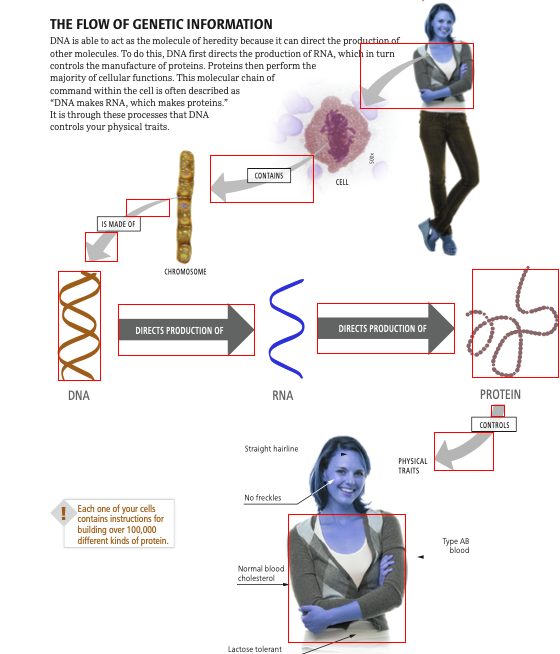

In [28]:
l =[(360, 43, 473, 108),
 (210, 155, 313, 202),
 (126, 199, 169, 216),
 (85, 232, 117, 261),
 (472, 269, 558, 377),
 (58, 271, 100, 380),
 (118, 304, 254, 355),
 (317, 303, 454, 353),
 (491, 405, 504, 416),
 (434, 432, 493, 470),
 (288, 514, 405, 642)]
img = cv2.imread("imgs/0.png")
for i in l:
    cv2.rectangle(img, (i[0],i[1]) , (i[2],i[3]) , (255,0,0), 1)
display(Image.fromarray(img))

In [156]:
image_path = "imgs/3.png"
img = cv2.imread(image_path)
ocr_boxes, ocr_box_text_dict = get_ocr_bounding_boxes(image_path)
ocr_boxes_copy = ocr_boxes.copy()
ocr_boxes_combined = combine_ocr_boxes(ocr_boxes, True)
text_dict = get_combined_texts(ocr_boxes_combined, ocr_boxes_copy, ocr_box_text_dict, image_path)
cleared_img = clear_bounding_boxes_from_image(ocr_boxes_copy, img)
color_palette = generate_color_palette(cleared_img)
#print(color_palette)
rgb_colors = process_color_palette(color_palette)
cleared_image_path = 'output.png'
bounding_boxes = color_filtering(rgb_colors , image_path)
boxes_with_large_area = reject_small_boxes(bounding_boxes)
final_boxes = join_overlapping_boxes(boxes_with_large_area)
img_cp = img.copy()
for i in final_boxes:
    img_cp = cv2.rectangle(img_cp, (i[0],i[1]) , (i[2],i[3]) , (255,0,0), 1)
#display(Image.fromarray(img_cp))
arrow_boxes = []
non_arrow_boxes = []
for i in final_boxes:
    if arrow_box_or_not(image_path, i) == True:
        arrow_boxes.append(i)
    else:
        non_arrow_boxes.append(i)
box_labels = {}
occupied_boxes = []
for i in final_boxes:
    min_dist = 30
    label = "NONE"
    box = None
    for j in text_dict.keys():
        if j not in occupied_boxes:
            dist = rect_distance(i,j)
            if dist < min_dist:
                min_dist = dist
                label = text_dict[j]
                box = j
    if box != None:
        occupied_boxes.append(j)
    box_labels[i] = label
#print (non_arrow_boxes)
#print (box_labels)
final_boxes.sort(key = lambda x: get_contour_precedence(x, img.shape[1]))
#first_box = final_boxes[0]
#connections = generate_connection_matrix(final_boxes)
#described = []
#length_of_described_boxes = []
#description = ""
#print (description)
#print (sortn(arrow_boxes))
#print(arrow_boxes)
#print(len(final_boxes))
#print(final_boxes)
filterl(text_dict)
filterl(box_labels)
#print(final_boxes)
#print(text_dict)
x = list(text_dict.values())
y= list(box_labels.values())
xi = list(text_dict.keys())

a={} #image label
for i in range(len(x)):
    if x[i] in y:continue
    a[xi[i]]=x[i]

b=box_labels #arrow label
########
#print(sortn(b))
for i in list(b):
    for j in text_dict:
        if check_a_rectangle_insisde_other_rectangle(i, j):
            if i in list(a):continue
            a[i] = b[i]
            del b[i]

final_text_output=""
cou=0
steps ={}
notes = {}

av= list(a.values())
ak = list(a.keys())
bv= list(b.values())
bk = list(b.keys())
combined = ak+bk

if(in_sorted_order(list(a.values())+y)==1):
    val = list(a.values())+y
    c=1
    arr=[]
    for i in range(len(val)):
        for j in range(len(val)):
            if val[j].split()[0][0]==str(c):
                print("step "+str(c)+" : "+val[j]+"\n")
                c+=1
                break
elif(in_sorted_order(list(a.values())+y)==2):
    val = list(a.values())+y
    c=ord('a')
    arr=[]
    for i in range(len(val)):
        for j in range(len(val)):
            if val[j].split()[0][0]==chr(c):
                print("step "+str(c-ord('a')+1)+" : "+val[j]+"\n")
                c+=1
                break
else:
    temp = []
    temp2 = []
    sc=1
    for i in final_boxes:
        
        ext_tup = extr(i,img)
        for j in ext_tup:
            curr = (i[0]+j[0],i[1]+j[1])
            for k in range(len(av)):
                if (distance_between_rectangle_and_point(ak[k],curr)<100 and (ak[k] not in temp)):
                    #print(av[k])
                    temp.append(ak[k])
                    final_text_output+=("Step "+str(sc)+" : "+av[k])+"\n"
                    sc+=1
                    break
            for l in range(len(bv)):
                if (distance_between_rectangle_and_point(bk[l],curr)<100 and (bk[l] not in temp2)):
                        #print(av[k])
                        temp2.append(bk[l])
                        if bv[l]=="NONE":continue
                        final_text_output+=("Note ( "+bv[l]+")")+"\n"
    for j in a:
        if (j not in temp):
            final_text_output+=("Note ("+a[j]+")")+"\n"
    for j in b:
        if (j not in temp2):
            final_text_output+=("Note ("+text_dict[j]+")")+"\n"
    print(final_text_output)


Step 1 : A growth factor is a normal, necessary protein that. under proper circumstances, promotes cell division. 
Note ( Growth factor gene )
Step 2 : Mutated growth factor gene 
Note ( If a growth factor gene is mutated, the resulting protein may promote cell division even when it is not appropriate. )
Step 3 : PRODUCES 
Step 4 : PRODUCES 
Step 5 : Normal growth factor protein 
Note ( Abnormal growth factor protein )
Step 6 : REGULATES NORMALLY 
Step 7 : UNCONTROLLED CELL CYCLE 
Step 8 : OVERSTIMULATES 
Step 9 : NORMAL CELL CYCLE 
Step 10 : Tumor 



In [152]:
text_dict

{(128, 44, 188, 59): 'PRODUCES ',
 (290, 43, 425, 59): 'REGULATES NORMALLY ',
 (128, 179, 188, 194): 'PRODUCES ',
 (295, 179, 396, 194): 'OVERSTIMULATES ',
 (511, 247, 536, 256): 'Tumor ',
 (122, 6, 162, 25): 'Growth factor gene ',
 (458, 33, 495, 50): 'NORMAL CELL CYCLE ',
 (228, 81, 280, 100): 'Normal growth factor protein ',
 (455, 172, 497, 189): 'UNCONTROLLED CELL CYCLE ',
 (222, 217, 285, 236): 'Abnormal growth factor protein ',
 (124, 129, 182, 148): 'Mutated growth factor gene ',
 (22,
  141,
  70,
  225): 'If a growth factor gene is mutated, the resulting protein may promote cell division even when it is not appropriate. ',
 (22,
  10,
  73,
  93): 'A growth factor is a normal, necessary protein that. under proper circumstances, promotes cell division. '}

In [137]:
for i in list(b):
    for j in text_dict:
        if check_a_rectangle_insisde_other_rectangle(i, j):
            a[i] = b[i]
            del b[i]
            

In [131]:
arr(b,text_dict)

'GIVE BIRTH '

In [153]:
a

{(511, 247, 536, 256): 'Tumor ',
 (228, 81, 280, 100): 'Normal growth factor protein ',
 (455, 172, 497, 189): 'UNCONTROLLED CELL CYCLE ',
 (124, 129, 182, 148): 'Mutated growth factor gene ',
 (22,
  10,
  73,
  93): 'A growth factor is a normal, necessary protein that. under proper circumstances, promotes cell division. ',
 (120, 153, 225, 220): 'PRODUCES ',
 (287, 18, 434, 84): 'REGULATES NORMALLY ',
 (287, 153, 518, 221): 'OVERSTIMULATES '}

In [154]:
b

{(236, 168, 273, 205): 'Abnormal growth factor protein ',
 (119, 18, 280, 84): 'PRODUCES ',
 (443, 24, 513, 88): 'NORMAL CELL CYCLE ',
 (82, 12, 111, 89): 'Growth factor gene ',
 (82,
  143,
  111,
  220): 'If a growth factor gene is mutated, the resulting protein may promote cell division even when it is not appropriate. '}

In [155]:
arrow_boxes

[(120, 153, 225, 220),
 (287, 18, 434, 84),
 (119, 18, 280, 84),
 (443, 24, 513, 88)]

In [29]:
def dot(vA, vB):
    return vA[0]*vB[0]+vA[1]*vB[1]
def ang(lineA, lineB):
    # Get nicer vector form
    vA = [(lineA[0][0]-lineA[1][0]), (lineA[0][1]-lineA[1][1])]
    vB = [(lineB[0][0]-lineB[1][0]), (lineB[0][1]-lineB[1][1])]
    # Get dot prod
    dot_prod = dot(vA, vB)
    # Get magnitudes
    magA = dot(vA, vA)**0.5
    magB = dot(vB, vB)**0.5
    # Get cosine value
    cos_ = dot_prod/magA/magB
    # Get angle in radians and then convert to degrees
    angle = math.acos(dot_prod/magB/magA)
    # Basically doing angle <- angle mod 360
    ang_deg = math.degrees(angle)%360

    if ang_deg-180>=0:
        # As in if statement
        return 360 - ang_deg
    else: 

        return ang_deg

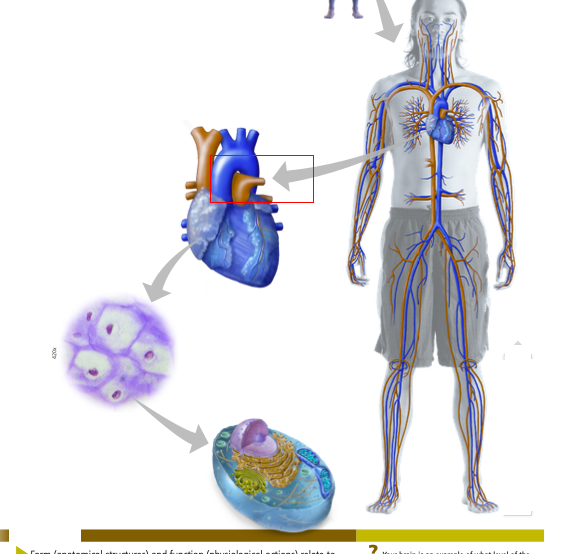

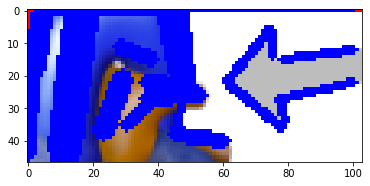

MULTILINESTRING ((46.269397 -7.324006499999999, 50.549261 30.7288705), (29.4736978 27.9719384, 60.5288102 25.8141616), (56.30190930000002 30.15423505, 79.5209467 -1.115032049999998), (86.07638914999998 41.66396565, 55.12628785 18.01223935))
POINT (50.0781656621626 26.54029512797887)


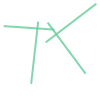

In [30]:
from shapely.geometry import MultiLineString,LineString
from shapely import affinity
import matplotlib.pyplot as plt
#xmin,ymin,xmax,ymax
i = (210, 155, 313, 202)
img = cv2.imread("output.png")
img = cv2.rectangle(img, (i[0],i[1]) , (i[2],i[3]) , (255,0,0), 1)
display(Image.fromarray(img))
H=i[3]-i[1]
W=i[2]-i[0]
cropped_image = img[i[1]:i[1]+H, i[0]:i[0]+W]
#print([X,Y,W,H])
plt.imshow(cropped_image)
gray = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
lines = lsd(gray)

for i in range(lines.shape[-2]):
    pt1 = (int(lines[i, 0]), int(lines[i, 1]))
    pt2 = (int(lines[i, 2]), int(lines[i, 3]))
    width = lines[i, 4]
    cv2.line(cropped_image, pt1, pt2, (0, 0, 255), int(np.ceil(width / 2)))
plt.imshow(cropped_image)
plt.show()
a=[]
b=[]
for line in lines:
    a.append(LineString([(line[0],line[1]),(line[2],line[3])]))
for i in range(len(a)):
    a[i] = affinity.scale(a[i], xfact=1.9, yfact=1.9)
for i in range(len(a)):
    for j in range(len(a)):
        if i==j:continue
        if(a[i].intersects(a[j])):
            an = ang(list(a[i].coords),list(a[j].coords))

            if(an<95 and an>80):

                anl = a[i].length
                bnl = a[j].length
                #print(anl,bnl)
                if(math.isclose(anl, bnl,rel_tol = 0.3)):
                    #print(anl,bnl)
                    b.append(a[i])

multi_line = MultiLineString(b)
multi_linea = MultiLineString(a)
print(multi_line)
print(multi_line[0].intersection(multi_line[1]))
multi_line

In [69]:
a,b = 0,[]

In [71]:
sorted(["-4","1","15","2"])

['-4', '1', '15', '2']

In [34]:
import imutils
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

NameError: name 'gray' is not defined

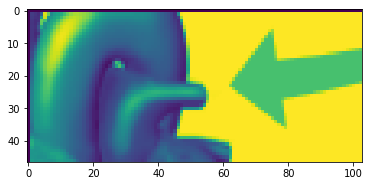

In [32]:
plt.imshow(gray)

In [33]:
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

print(extLeft,extRight,extTop,extBot)
max(extLeft,extRight,extTop,extBot)

(1, 1) (102, 46) (1, 1) (1, 46)


(102, 46)

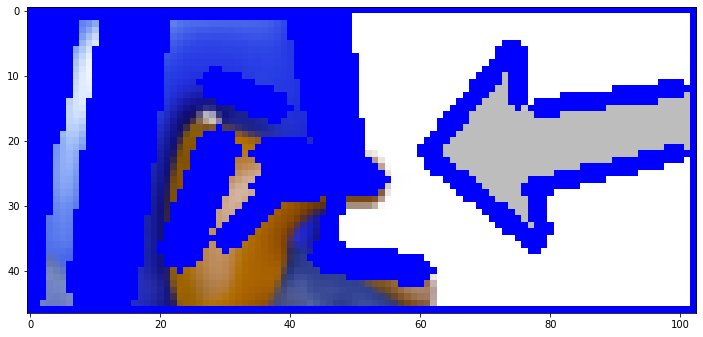

In [34]:
contours = cv2.findContours(gray, 
                            cv2.RETR_EXTERNAL,
                            cv2.CHAIN_APPROX_NONE)
cv2.drawContours(cropped_image, contours[0], -1, (0,0,255), thickness = 1)
fig, ax = plt.subplots(1, figsize=(12,8))
plt.imshow(cropped_image)

In [35]:
text_dict={}

In [36]:
def curved(image_path):
    global text_dict
    img = cv2.imread(image_path)
    ocr_boxes, ocr_box_text_dict = get_ocr_bounding_boxes(image_path)
    ocr_boxes_copy = ocr_boxes.copy()
    ocr_boxes_combined = combine_ocr_boxes(ocr_boxes, True)
    text_dict = get_combined_texts(ocr_boxes_combined, ocr_boxes_copy, ocr_box_text_dict, image_path)
    cleared_img = clear_bounding_boxes_from_image(ocr_boxes_copy, img)
    color_palette = generate_color_palette(cleared_img)
    #print(color_palette)
    rgb_colors = process_color_palette(color_palette)
    cleared_image_path = 'output.png'
    bounding_boxes = color_filtering(rgb_colors , image_path)
    boxes_with_large_area = reject_small_boxes(bounding_boxes)
    final_boxes = join_overlapping_boxes(boxes_with_large_area)
    img_cp = img.copy()
    #for i in final_boxes:
    #    img_cp = cv2.rectangle(img_cp, (i[0],i[1]) , (i[2],i[3]) , (255,0,0), 1)
    #display(Image.fromarray(img_cp))
    arrow_boxes = []
    non_arrow_boxes = []
    for i in final_boxes:
        if arrow_box_or_not(image_path, i) == True:
            arrow_boxes.append(i)
        else:
            non_arrow_boxes.append(i)
    box_labels = {}
    occupied_boxes = []
    for i in final_boxes:
        min_dist = 30
        label = "NONE"
        box = None
        for j in text_dict.keys():
            if j not in occupied_boxes:
                dist = rect_distance(i,j)
                if dist < min_dist:
                    min_dist = dist
                    label = text_dict[j]
                    box = j
        if box != None:
            occupied_boxes.append(j)
        box_labels[i] = label
    #print (non_arrow_boxes)
    #print (box_labels)
    final_boxes.sort(key = lambda x: get_contour_precedence(x, img.shape[1]))
    #print(text_dict)
    return(final_boxes)
    
    

In [37]:
def get_arrow_head(cropped_image):
    gray = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
    lines = lsd(gray)

    for i in range(lines.shape[-2]):
        pt1 = (int(lines[i, 0]), int(lines[i, 1]))
        pt2 = (int(lines[i, 2]), int(lines[i, 3]))
        width = lines[i, 4]
        cv2.line(cropped_image, pt1, pt2, (0, 0, 255), int(np.ceil(width / 2)))
    #plt.imshow(cropped_image)
    #plt.show()
    a=[]
    b=[]
    for line in lines:
        a.append(LineString([(line[0],line[1]),(line[2],line[3])]))
    for i in range(len(a)):
        a[i] = affinity.scale(a[i], xfact=1.9, yfact=1.9)
    for i in range(len(a)):
        for j in range(len(a)):
            if i==j:continue
            if(a[i].intersects(a[j])):
                an = ang(list(a[i].coords),list(a[j].coords))

                if(an<95 and an>80):

                    anl = a[i].length
                    bnl = a[j].length
                    #print(anl,bnl)
                    if(math.isclose(anl, bnl,rel_tol = 0.3)):
                        #print(anl,bnl)
                        b.append(a[i])

    multi_line = MultiLineString(b)
    multi_linea = MultiLineString(a)
    #print(multi_line)
    point = multi_line[0].intersection(multi_line[1])
    return(point.x,point.y)
    #multi_line

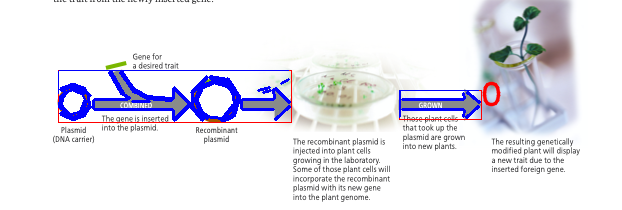

In [144]:
image_src ="imgs/5.png"
l = curved(image_src)
l = sortn(l)
img = cv2.imread(image_src)
arr = []
for i in l:
    cv2.rectangle(img, (i[0],i[1]) , (i[2],i[3]) , (255,0,0), 1)
    H=i[3]-i[1]
    W=i[2]-i[0]
    cropped_image = img[i[1]:i[1]+H, i[0]:i[0]+W]
    try:
        nx,ny = (get_arrow_head(cropped_image))
        
        #print(nx,ny)
        arr.append((int(nx+i[0]),int(ny+i[1])))
    except:pass
arrows = {}
for k in range(len(arr)):
    cv2.putText(img, str(k), arr[k], cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
    arrows[k]=arr[k]
display(Image.fromarray(img))

In [152]:
image_src ="imgs/0.png"
l = curved(image_src)
l = sortn(l)
img = cv2.imread(image_src)
arr = []
for i in l:
    cv2.rectangle(img, (i[0],i[1]) , (i[2],i[3]) , (255,0,0), 1)
    H=i[3]-i[1]
    W=i[2]-i[0]
    cropped_image = img[i[1]:i[1]+H, i[0]:i[0]+W]
    try:
        nx,ny = (get_arrow_head(cropped_image))
        
        #print(nx,ny)
        arr.append((int(nx+i[0]),int(ny+i[1])))
    except:pass
arrows = {}
for k in range(len(arr)):
    arrows[k]=arr[k]
oc=[]
occ=[]
oc2 = []
occ2 = []
text_dict_f = filterl(text_dict)
tdk = list(text_dict_f.keys())
tdv = list(text_dict_f.values())
for i in range(len(arrows)):
    m = 1000
    for j in range(len(tdk)):
        if (tdk[j] in occ):continue
        d = distance_between_rectangle_and_point(tdk[j],arrows[i])
        
        if m>d and d<200:
            m=d
            fk=tdv[j]
            ffk = tdk[j]
            
        
    oc.append(text_dict_f[ffk])
    occ.append(ffk)
for i in range(len(arrows)):
    m = 1000
    for j in range(len(tdk)):
        if ((tdk[j] in occ) or (tdk[j] in occ2)):continue
        d = distance_between_rectangle_and_point(tdk[j],arrows[i])
        
        if m>d and d<200:
            m=d
            fk=tdv[j]
            ffk = tdk[j]
            
        
    oc2.append(text_dict_f[ffk])
    occ2.append(ffk)
for i in range(len(oc)):
    print("step "+str(i+1)+" "+oc[i]+"\n"+"(note: "+oc2[i]+")\n")

step 1 CELL 
(note: PHYSICAL TRAITS )

step 2 CONTAINS 
(note: CHROMOSOME )

step 3 IS MADE OF 
(note: DNA )

step 4 DIRECTS PRODUCTION OF 
(note: RNA )

step 5 DIRECTS PRODUCTION OF 
(note: PROTEIN )

step 6 PHYSICAL TRAITS 
(note: CONTROLS )



In [115]:
text_dict

{(510, 350, 526, 359): '- ',
 (14, 530, 76, 540): 'CORE IDEA ',
 (505,
  364,
  529,
  510): 'there are stars in the Milky Way galaxy. There are more cells in your body than ',
 (87,
  458,
  198,
  514): 'CELL Your body is made of trillions of individual cells. The generalized animal cell shown here is similar to a typical epithelial cell found in your body. ',
 (135,
  37,
  367,
  94): 'ORGAN SYSTEM Each organ system in your body consists of teams of organs that together perform an important body function. As you exercise, your circulatory system (including your heart and blood vessels) transports materials throughout the body, providing your muscle cells with oxygen and carrying away wastes. ',
 (185,
  312,
  322,
  395): 'TISSUE A tissue is an integrated group of similar cells that together perform a function. Here you can see many epithelial cells overlapping to form sheets of smooth tissue. Similar epithelial tissue lines the internal and external surfaces of the heart and othe

In [119]:
def filterl(dic):
    dk = list(dic.keys())
    dv = list(dic.values())
    for i in range(len(dk)):
        ar = dv[i].split()
        if len(ar)>75:
            dic.pop(dk[i])
        if len(ar) == 1:
            if len(ar[0]) == 1:
                dic.pop(dk[i])
            
    return(dic)
text_dict_f = filterl(text_dict)
print(text_dict_f)

{(14, 530, 76, 540): 'CORE IDEA ', (505, 364, 529, 510): 'there are stars in the Milky Way galaxy. There are more cells in your body than ', (87, 458, 198, 514): 'CELL Your body is made of trillions of individual cells. The generalized animal cell shown here is similar to a typical epithelial cell found in your body. ', (135, 37, 367, 94): 'ORGAN SYSTEM Each organ system in your body consists of teams of organs that together perform an important body function. As you exercise, your circulatory system (including your heart and blood vessels) transports materials throughout the body, providing your muscle cells with oxygen and carrying away wastes. ', (185, 312, 322, 395): 'TISSUE A tissue is an integrated group of similar cells that together perform a function. Here you can see many epithelial cells overlapping to form sheets of smooth tissue. Similar epithelial tissue lines the internal and external surfaces of the heart and other organs. ', (15, 139, 162, 251): 'ORGAN An organ consist

In [78]:
dk = list(text_dict_f.keys())
dv = list(text_dict_f.values())
ft = ""
oc = []
for i in range(len(arrows)):
    
    m = 1000
    fk = ()
    ffk = ()
    for j in range(len(dk)):
        d = distance_between_rectangle_and_point(dk[j],arrows[i])
        
        if m>d:
            m=d
            fk=dv[j]
            ffk = dk[j]
            
        
    oc.append(text_dict_f[ffk])
    print(m,fk)
print(ft,oc)


341.5406271587613 there are stars in the Milky Way galaxy. There are more cells in your body than 
289.61353559528254 CELL Your body is made of trillions of individual cells. The generalized animal cell shown here is similar to a typical epithelial cell found in your body. 
213.0 CELL Your body is made of trillions of individual cells. The generalized animal cell shown here is similar to a typical epithelial cell found in your body. 
60.0 CELL Your body is made of trillions of individual cells. The generalized animal cell shown here is similar to a typical epithelial cell found in your body. 
 ['there are stars in the Milky Way galaxy. There are more cells in your body than ', 'CELL Your body is made of trillions of individual cells. The generalized animal cell shown here is similar to a typical epithelial cell found in your body. ', 'CELL Your body is made of trillions of individual cells. The generalized animal cell shown here is similar to a typical epithelial cell found in your bod

In [83]:
occ = [""]
for i in range(len(arrows)):
    if i==1:
        continue
    m2 = 1000

    ffk = ()
    #ffkk=()
    for j in range(len(dk)):
        if dv[j] in oc or dv[j] in occ:
            continue
        d = distance_between_rectangle_and_point(dk[j],arrows[i])
        if m2>d:
            m2=d
            fkk=dv[j]
            ffkk=dk[j]
    print(ffkk)
    occ.append(text_dict_f[ffkk])
    #print(m,fkk)
#print(occ)

for i in range(len(oc)):
    print("step "+str(i+1)+": "+oc[i]+""+occ[i])

(14, 530, 76, 540)
(14, 530, 76, 540)
(14, 530, 76, 540)
step 1: there are stars in the Milky Way galaxy. There are more cells in your body than 
step 2: CELL Your body is made of trillions of individual cells. The generalized animal cell shown here is similar to a typical epithelial cell found in your body. CORE IDEA 
step 3: CELL Your body is made of trillions of individual cells. The generalized animal cell shown here is similar to a typical epithelial cell found in your body. CORE IDEA 
step 4: CELL Your body is made of trillions of individual cells. The generalized animal cell shown here is similar to a typical epithelial cell found in your body. CORE IDEA 


In [82]:
#text_dict_f

{(14, 530, 76, 540): 'CORE IDEA ',
 (505,
  364,
  529,
  510): 'there are stars in the Milky Way galaxy. There are more cells in your body than ',
 (87,
  458,
  198,
  514): 'CELL Your body is made of trillions of individual cells. The generalized animal cell shown here is similar to a typical epithelial cell found in your body. '}

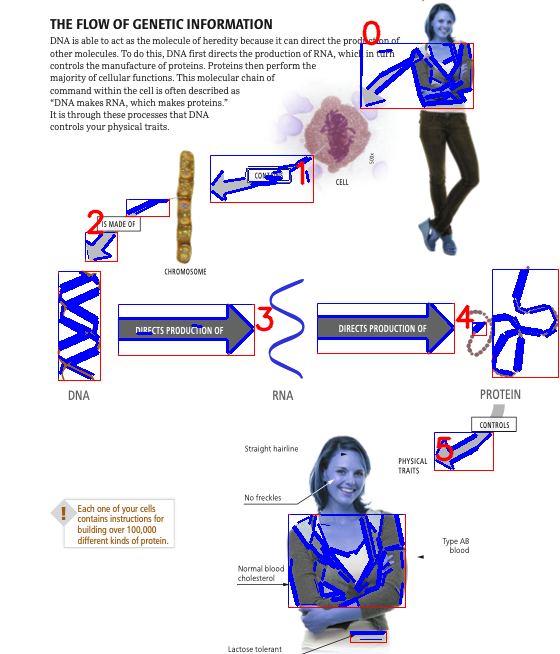

In [109]:
image_src ="imgs/0.png"
l = curved(image_src)
l = sortn(l)
img = cv2.imread(image_src)
arr = []
for i in l:
    cv2.rectangle(img, (i[0],i[1]) , (i[2],i[3]) , (255,0,0), 1)
    H=i[3]-i[1]
    W=i[2]-i[0]
    cropped_image = img[i[1]:i[1]+H, i[0]:i[0]+W]
    try:
        nx,ny = (get_arrow_head(cropped_image))
        
        #print(nx,ny)
        arr.append((int(nx+i[0]),int(ny+i[1])))
    except:pass
arrows = {}
for k in range(len(arr)):
    cv2.putText(img, str(k), arr[k], cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
    arrows[k]=arr[k]
display(Image.fromarray(img))


In [110]:
text_dict_f = filterl(text_dict)
dk = list(text_dict_f.keys())
dv = list(text_dict_f.values())
ft = ""
oc = []
for i in range(len(arrows)):
    
    m = 1000
    fk = ()
    ffk = ()
    for j in range(len(dk)):
        
        d = distance_between_rectangle_and_point(dk[j],arrows[i])
        
        if m>d:
            m=d
            fk=dv[j]
            ffk = dk[j]
            
        
    oc.append(text_dict[ffk])
    #print(m,fk)
#print(ft,oc)
occ = []
for i in range(len(arrows)):
    m2 = 1000
    #ffk = ()
    #ffkk=()
    for j in range(len(dk)):
        if dv[j] in oc or dv[j] in occ:
            continue
        d = distance_between_rectangle_and_point(dk[j],arrows[i])
        if m2>d:
            m2=d
            fkk=dv[j]
            ffkk=dk[j]
    #print(ffkk)
    occ.append(text_dict[ffkk])
    #print(m,fkk)
#print(occ)

for i in range(len(oc)):
    print("step "+str(i+1)+": "+oc[i]+"\n note("+occ[i]+")")

step 1: CELL 
 note(CHROMOSOME )
step 2: CONTAINS 
 note(RNA )
step 3: IS MADE OF 
 note(DNA )
step 4: DIRECTS PRODUCTION OF 
 note(Straight hairline )
step 5: DIRECTS PRODUCTION OF 
 note(PROTEIN )
step 6: PHYSICAL TRAITS 
 note(CONTROLS )


In [102]:
text_dict

{(14, 530, 76, 540): 'CORE IDEA ',
 (505,
  364,
  529,
  510): 'there are stars in the Milky Way galaxy. There are more cells in your body than ',
 (87,
  458,
  198,
  514): 'CELL Your body is made of trillions of individual cells. The generalized animal cell shown here is similar to a typical epithelial cell found in your body. ',
 (135,
  37,
  367,
  94): 'ORGAN SYSTEM Each organ system in your body consists of teams of organs that together perform an important body function. As you exercise, your circulatory system (including your heart and blood vessels) transports materials throughout the body, providing your muscle cells with oxygen and carrying away wastes. ',
 (185,
  312,
  322,
  395): 'TISSUE A tissue is an integrated group of similar cells that together perform a function. Here you can see many epithelial cells overlapping to form sheets of smooth tissue. Similar epithelial tissue lines the internal and external surfaces of the heart and other organs. '}

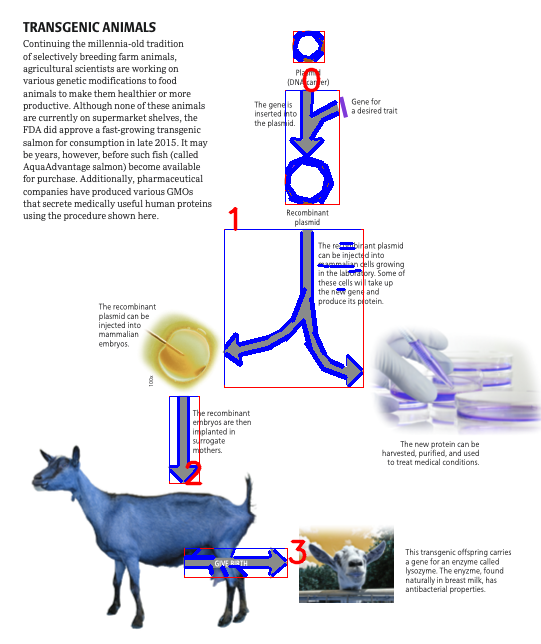

In [89]:
image_src ="imgs/2.png"
l = curved(image_src)
l = sortn(l)
img = cv2.imread(image_src)
arr = []
for i in l:
    cv2.rectangle(img, (i[0],i[1]) , (i[2],i[3]) , (255,0,0), 1)
    H=i[3]-i[1]
    W=i[2]-i[0]
    cropped_image = img[i[1]:i[1]+H, i[0]:i[0]+W]
    try:
        nx,ny = (get_arrow_head(cropped_image))
        
        #print(nx,ny)
        arr.append((int(nx+i[0]),int(ny+i[1])))
    except:pass
arrows = {}
for k in range(len(arr)):
    cv2.putText(img, str(k), arr[k], cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
    arrows[k]=arr[k]
display(Image.fromarray(img))

In [354]:
text_dict_f = filterl(text_dict)
dk = list(text_dict_f.keys())
dv = list(text_dict_f.values())
ft = ""
oc = []
for i in range(len(arrows)):
    
    m = 1000
    fk = ()
    ffk = ()
    for j in range(len(dk)):
        d = distance_between_rectangle_and_point(dk[j],arrows[i])
        
        if m>d:
            m=d
            fk=dv[j]
            ffk = dk[j]
            
        
    oc.append(text_dict_f[ffk])
    #print(m,fk)
#print(ft,oc)
occ = []
for i in range(len(arrows)):
    m2 = 1000
    ffk = ()
    ffkk=()
    for j in range(len(dk)):
        if dv[j] in oc or dv[j] in occ:
            continue
        d = distance_between_rectangle_and_point(dk[j],arrows[i])
        if m2>d:
            m2=d
            fkk=dv[j]
            ffkk=dk[j]
    occ.append(text_dict_f[ffkk])
    #print(m,fkk)
#print(occ)

for i in range(len(oc)):
    print("step "+str(i+1)+": "+oc[i]+"\n note("+occ[i]+")")

step 1: Plasmid (DNA carrier) 
 note(The gene is inserted into the plasmid. )
step 2: Recombinant plasmid 
 note(The recombinant plasmid can be injected into mammalian cells growing in the laboratory. Some of these cells will take up the new gene and produce its protein. )
step 3: The recombinant embryos are then implanted in surrogate mothers. 
 note(The recombinant plasmid can be injected into mammalian embryos. )
step 4: GIVE BIRTH 
 note(This transgenic offspring carries a gene for an enzyme called lysozyme. The enyzme, found naturally in breast milk, has antibacterial properties. )


In [51]:
def cu_flow(image_path):
    img = cv2.imread(image_path)
    ocr_boxes, ocr_box_text_dict = get_ocr_bounding_boxes(image_path)
    ocr_boxes_copy = ocr_boxes.copy()
    ocr_boxes_combined = combine_ocr_boxes(ocr_boxes, True)
    text_dict = get_combined_texts(ocr_boxes_combined, ocr_boxes_copy, ocr_box_text_dict, image_path)
    text_dict_f = filterl(text_dict)
    l = curved(image_path)
    l = sortn(l)
    img = cv2.imread(image_path)
    arr = []
    for i in l:
        cv2.rectangle(img, (i[0],i[1]) , (i[2],i[3]) , (255,0,0), 1)
        H=i[3]-i[1]
        W=i[2]-i[0]
        cropped_image = img[i[1]:i[1]+H, i[0]:i[0]+W]
        try:
            nx,ny = (get_arrow_head(cropped_image))

            #print(nx,ny)
            arr.append((int(nx+i[0]),int(ny+i[1])))
        except:pass
    arrows = {}
    #print(arr)
    #display(Image.fromarray(img))
    for k in range(len(arr)):
        cv2.putText(img, str(k), arr[k], cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
        arrows[k]=arr[k]
    text_dict_f = filterl(text_dict)
    dk = list(text_dict_f.keys())
    dv = list(text_dict_f.values())
    ft = ""
    #print(arrows)
    oc = []
    for i in range(len(arrows)):

        m = 1000
        fk = ()
        ffk = ()
        for j in range(len(dk)):
            d = distance_between_rectangle_and_point(dk[j],arrows[i])

            if m>d:
                m=d
                fk=dv[j]
                ffk = dk[j]


        oc.append(text_dict_f[ffk])
        #print(m,fk)
    #print(ft,oc)
    occ = [""]
    for i in range(len(arrows)):
        if i==1:
            continue
        m2 = 1000

        ffk = ()
        ffkk=()
        for j in range(len(dk)):
            if dv[j] in oc or dv[j] in occ:
                continue
            d = distance_between_rectangle_and_point(dk[j],arrows[i])
            if m2>d:
                m2=d
                fkk=dv[j]
                ffkk=dk[j]
        occ.append(text_dict_f[ffkk])
        #print(m,fkk)
    #print(occ)

    output=""
    #print(oc,occ)
    for i in range(len(oc)):
        output+=("step "+str(i+1)+": "+oc[i]+"\n note("+occ[i]+")\n")
    return output

In [61]:
print(cu_flow("imgs/4.png"))

step 1: Rising blood glucose level (after a meal, for example) 
 note()
step 2: Homeostasis 
 note(Normal blood glucose level )



In [319]:
occ = []
for i in range(len(arrows)):
    #if i==1:
    #   continue
    m2 = 1000

    ffk = ()
    ffkk=()
    for j in range(len(dk)):
        if dv[j] in oc or dv[j] in occ:
            continue
        d = distance_between_rectangle_and_point(dk[j],arrows[i])
        if m2>d:
            m2=d
            fkk=dv[j]
            ffkk=dk[j]
    occ.append(text_dict_f[ffkk])
    #print(m,fkk)
#print(occ)

for i in range(len(oc)):
    print("step "+str(i+1)+": "+oc[i]+""+occ[i])

step 1: Plasmid (DNA carrier) The gene is inserted into the plasmid. 
step 2: Recombinant plasmid The recombinant plasmid can be injected into mammalian cells growing in the laboratory. Some of these cells will take up the new gene and produce its protein. 
step 3: The recombinant embryos are then implanted in surrogate mothers. The recombinant plasmid can be injected into mammalian embryos. 
step 4: GIVE BIRTH This transgenic offspring carries a gene for an enzyme called lysozyme. The enyzme, found naturally in breast milk, has antibacterial properties. 


In [251]:
text_dict_f

{(254, 170, 284, 180): 'CONTAINS ',
 (334, 178, 349, 186): 'CELL ',
 (101, 219, 136, 228): 'IS MADE OF ',
 (163, 266, 206, 276): 'CHROMOSOME ',
 (134, 325, 224, 335): 'DIRECTS PRODUCTION OF ',
 (337, 323, 428, 333): 'DIRECTS PRODUCTION OF ',
 (67, 389, 91, 401): 'DNA ',
 (271, 389, 295, 401): 'RNA ',
 (479, 387, 521, 399): 'PROTEIN ',
 (477, 419, 510, 429): 'CONTROLS ',
 (243, 443, 299, 454): 'Straight hairline ',
 (242, 493, 283, 502): 'No freckles ',
 (227, 644, 281, 653): 'Lactose tolerant ',
 (396, 456, 428, 474): 'PHYSICAL TRAITS ',
 (442, 536, 470, 554): 'Type AB blood ',
 (236, 563, 285, 582): 'Normal blood cholesterol '}

In [33]:
def get_ocr_bounding_boxes(image_path):
    ocr_boxes = []
    ocr_box_text_dict = {}
    res = ms_ocr.result_microsoft_api(image_path)
    for i in range(len(res[0]['lines'])):
        bbox = res[0]['lines'][i]['boundingBox']
        xmin = min(bbox[0],bbox[2],bbox[4],bbox[6])
        ymin = min(bbox[1],bbox[3],bbox[5],bbox[7])
        xmax = max(bbox[0],bbox[2],bbox[4],bbox[6])
        ymax = max(bbox[1],bbox[3],bbox[5],bbox[7])
        bounding_box = (xmin,ymin,xmax,ymax)
        ocr_box_text_dict[bounding_box] = res[0]['lines'][i]['text']
        ocr_boxes.append(bounding_box)
    return ocr_boxes, ocr_box_text_dict

In [34]:
def clear_ocr(image_path):
    ocr_boxes, ocr_box_text_dict = get_ocr_bounding_boxes(image_path)
    img = cv2.imread(image_path)
    for i in ocr_boxes:
        img[i[1]:i[3] , i[0]:i[2]] = (255,255,255)
    display(Image.fromarray(img))
    cv2.imwrite("cleared.png" , img)
    return "cleared.png"

202
202


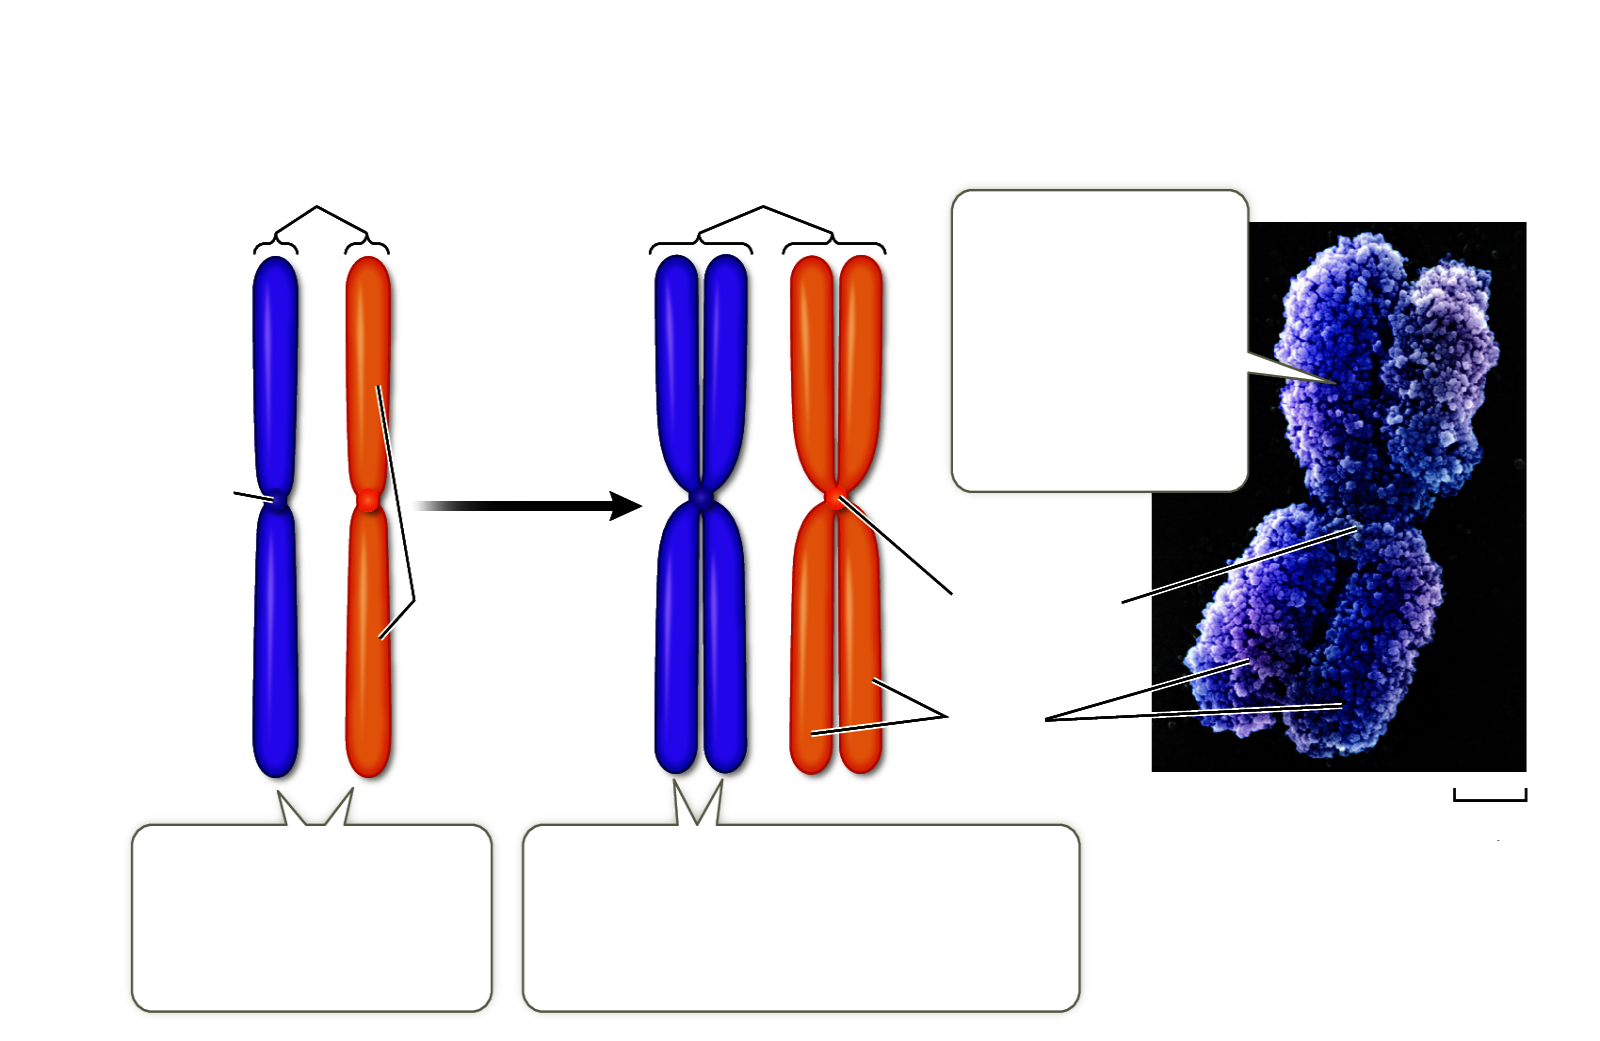

In [35]:
ocr_boxes, ocr_text_dict = get_ocr_bounding_boxes(image_path)
image_path = clear_ocr(image_path)
color_codes = [[185,186,187] , [98,100,99]]
bbox = color_filtering(color_codes, image_path)

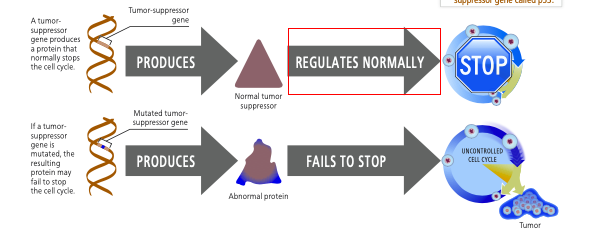